In [345]:
# import
import pandas as pd
import numpy as np

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
%matplotlib inline

In [346]:
# load datasets
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [347]:
all_series = {
    "Monthly Sales of Company X": sales_of_company_x["Count"],
    "Daily Female Births": female_births["Count"]
}

In [348]:
# Dickey-Fuller Test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [349]:
# Функция отрисовки графика
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

______________________________________________________
Monthly Sales of Company X
Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


______________________________________________________
Daily Female Births
Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


<Figure size 1400x600 with 0 Axes>

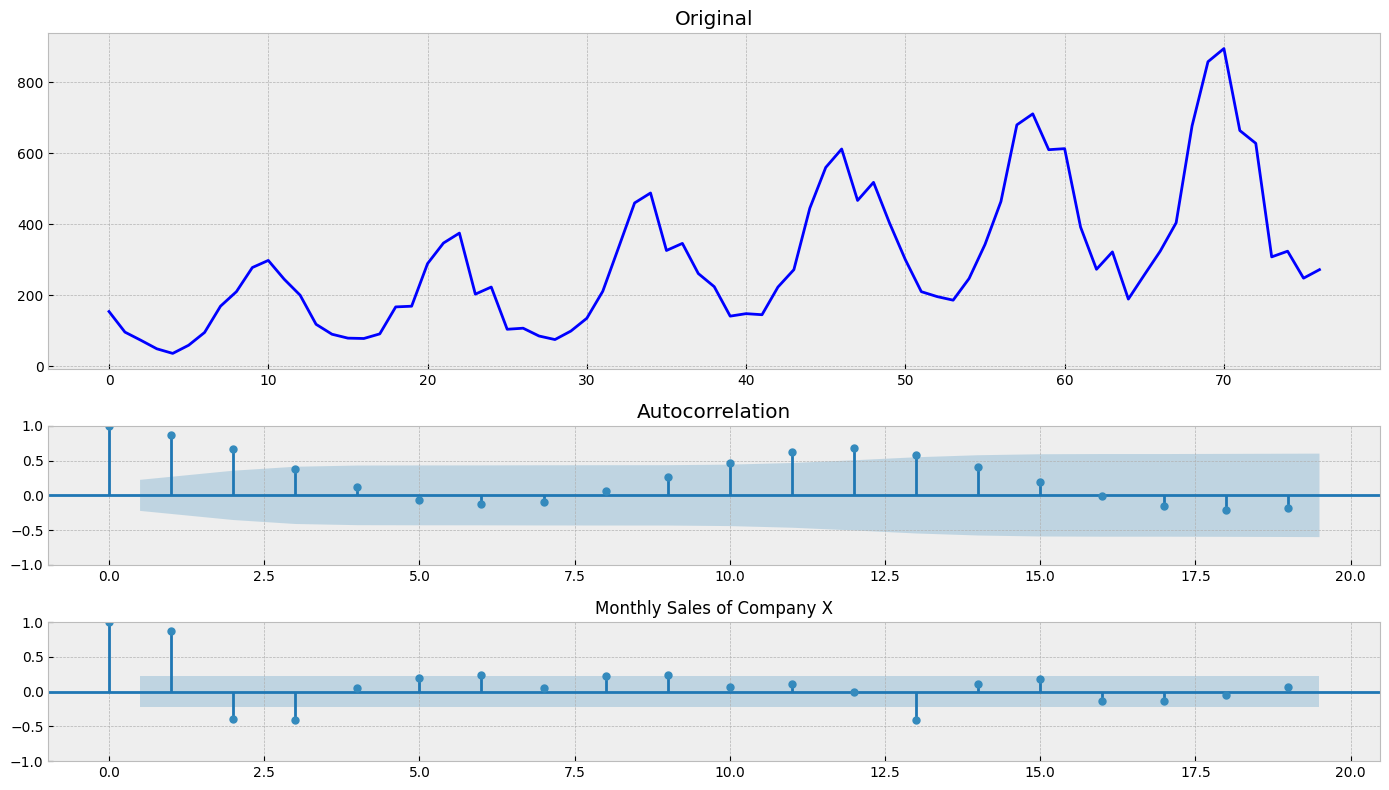

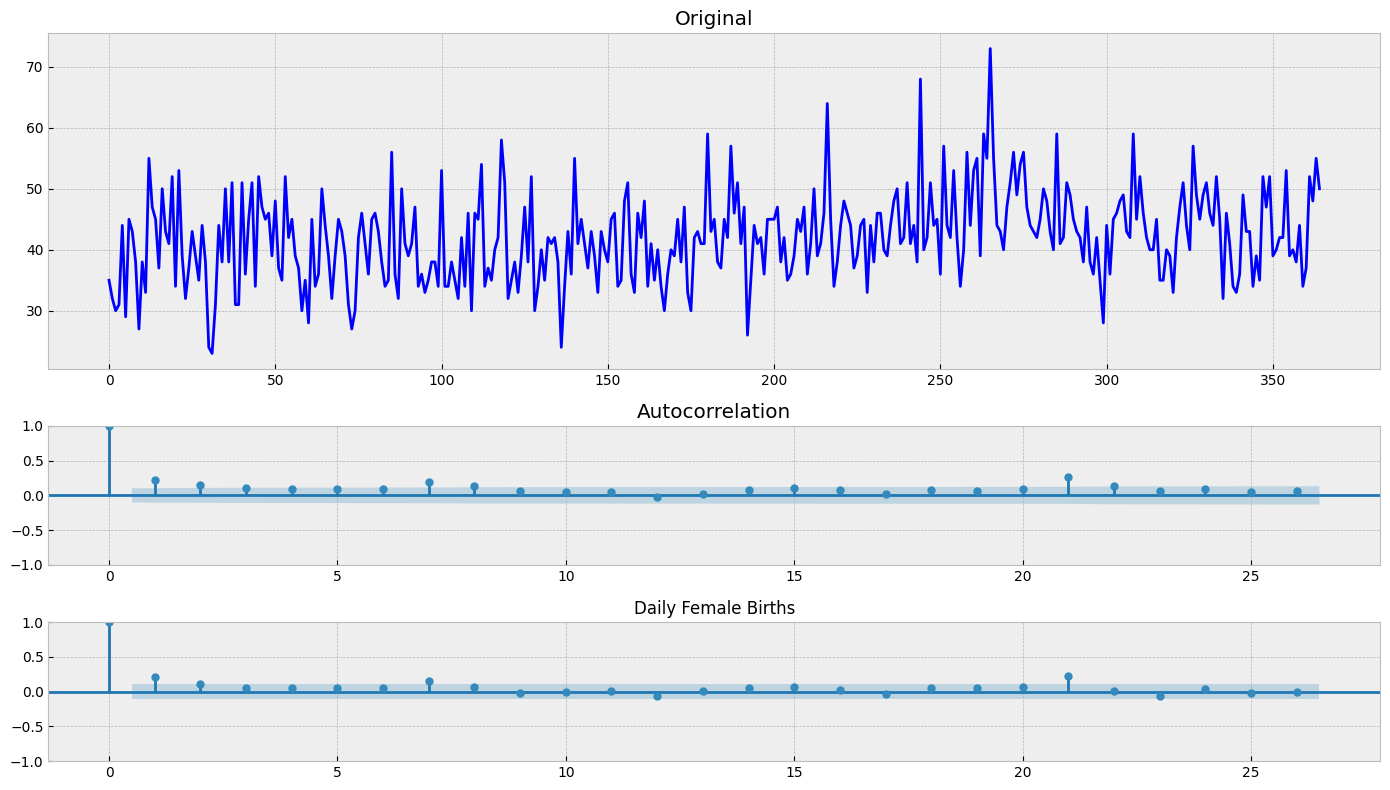

In [350]:
# Проводим тест на стационарность
plt.figure(figsize=(14, 6))

layout = (3, 2)
for i, series in all_series.items():
    print("______________________________________________________")
    print(i)
    tsplot(series)  
    plt.title(i)
    plt.tight_layout()

После проведения теста, видим, что:
- временной ряд Monthly Sales of Company X - не стационарен
- временной ряд Daily Female Births - стационарен

Применение методов:

1. Скользящее среднее

In [351]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

Monthly Sales of Company X

In [352]:
ser_sales = moving_average(sales_of_company_x["Count"], 3)

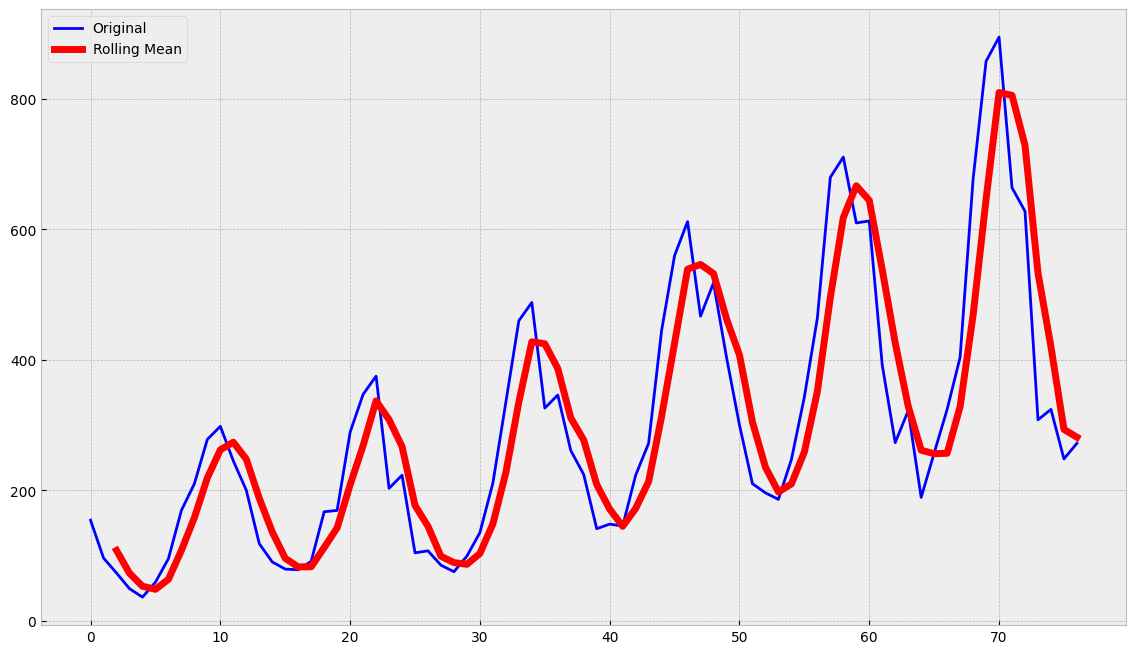

In [353]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue', label='Original')
    plt.plot(ser_sales, color='red', linewidth=5, label='Rolling Mean')
    plt.legend()

Daily Female Births

In [354]:
ser_female = moving_average(female_births["Count"], 3)

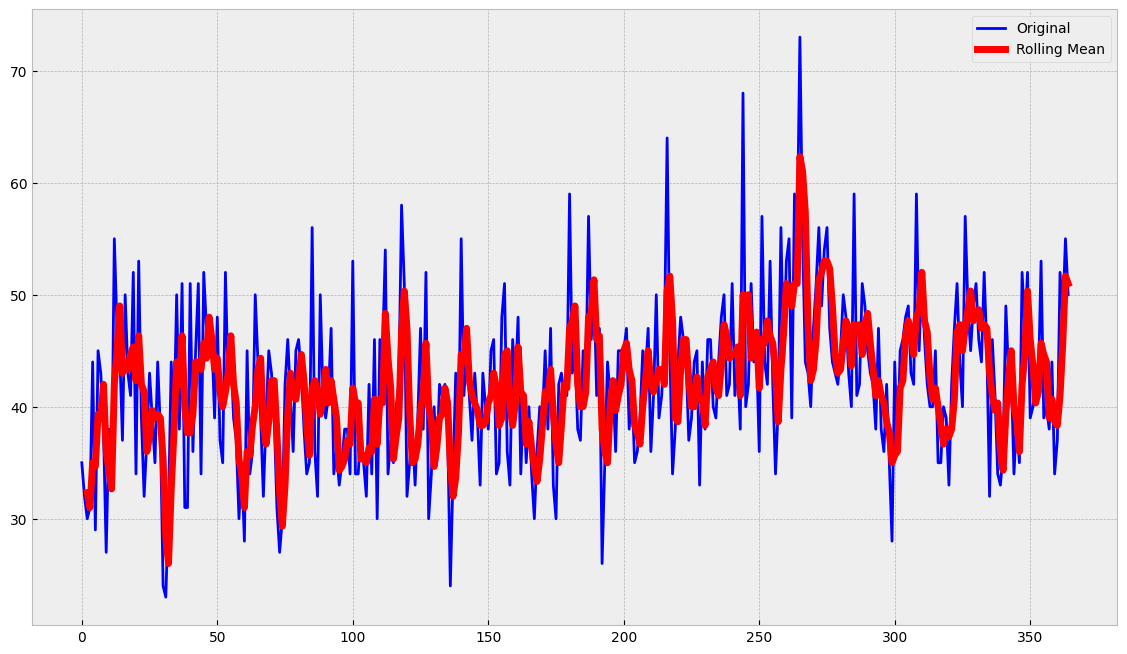

In [355]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births['Count'], color='blue', label='Original')
    plt.plot(ser_female, color='red', linewidth=5, label='Rolling Mean')
    plt.legend()

2. Усредняем ряд МА

In [356]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = pd.concat([new_series, pd.Series([new_series[-N:].mean()])], ignore_index=True)
    return new_series

Monthly Sales of Company X

In [357]:
series_pred = predict(sales_of_company_x["Count"], 10, 20)

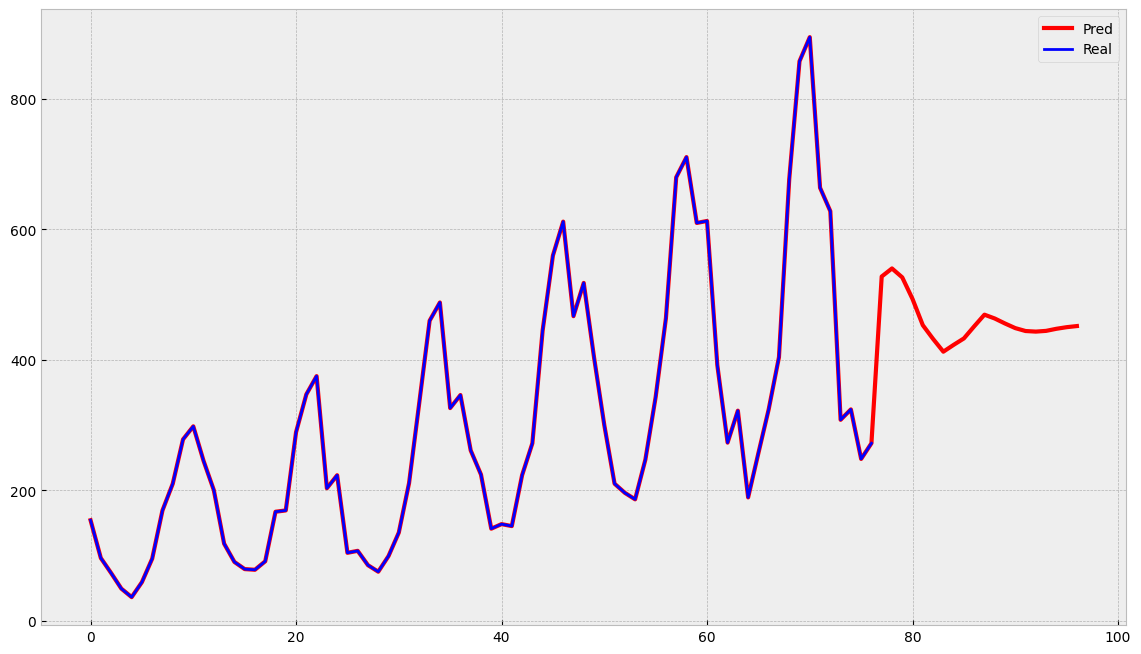

In [358]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='red', linewidth='3', label='Pred')
    plt.plot(sales_of_company_x["Count"], color='blue', label='Real')
    plt.legend()

Daily Female Births

In [359]:
series_pred_female = predict(female_births["Count"], 10, 20)

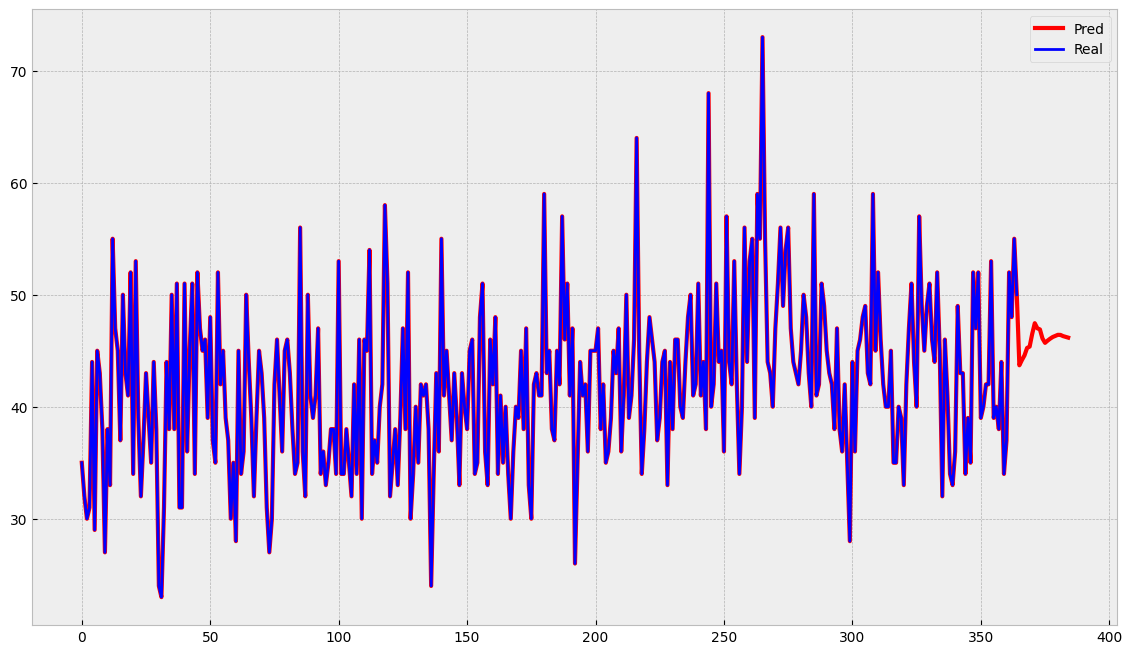

In [360]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred_female, color='red', linewidth='3', label='Pred')
    plt.plot(female_births["Count"], color='blue', label='Real')
    plt.legend()

3. Применение WMA

In [361]:
def weighted_moving_average(series, n, weights):
    if not isinstance(series, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [362]:
wma_sales = weighted_moving_average(sales_of_company_x["Count"], 7, [1,1,2,3,5,8,13])
wma_female = weighted_moving_average(female_births["Count"], 7, [1,1,2,3,5,8,13])

Monthly Sales of Company X

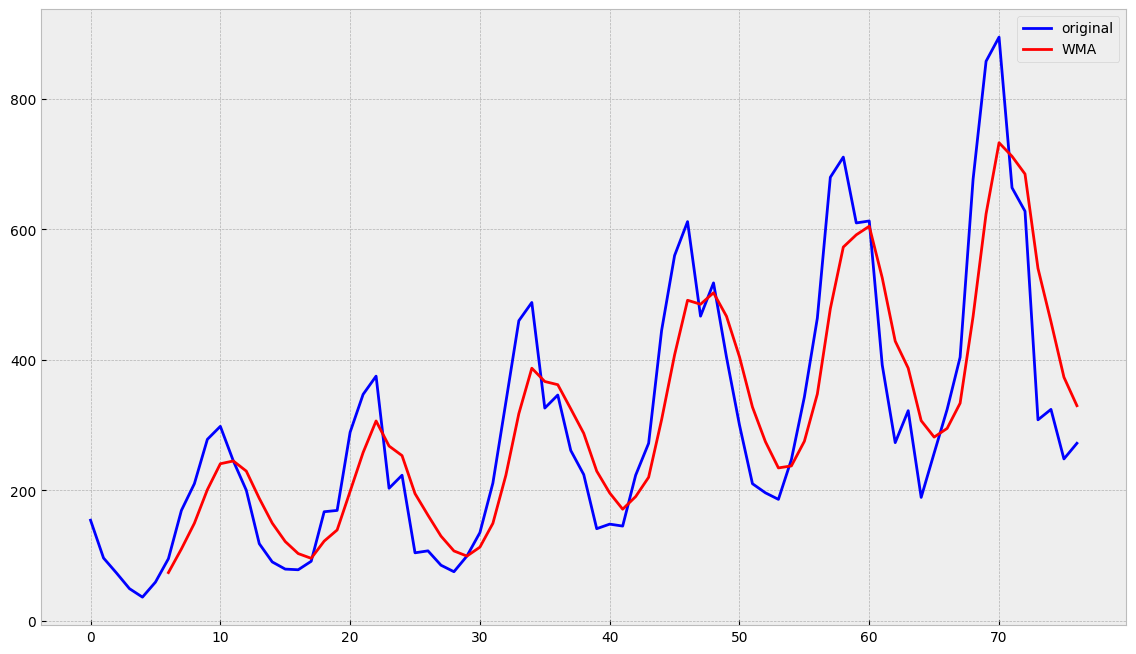

In [363]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    
    plt.plot(wma_sales, color='red', linewidth='2', label='WMA')
    plt.legend()

Daily Female Births

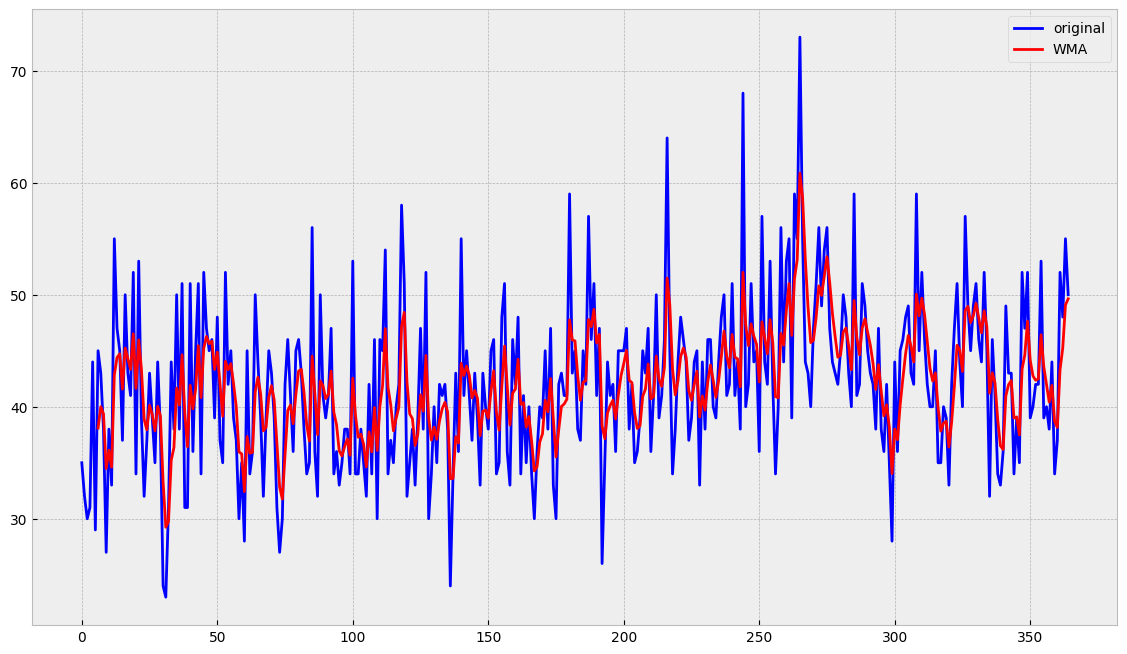

In [364]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    
    plt.plot(wma_female, color='red', linewidth='2', label='WMA')
    plt.legend()

5. Применение EMA

In [365]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n - 1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    return pd.concat([series, pd.Series(predictions)], ignore_index=True), pd.Series(result)

Monthly Sales of Company X

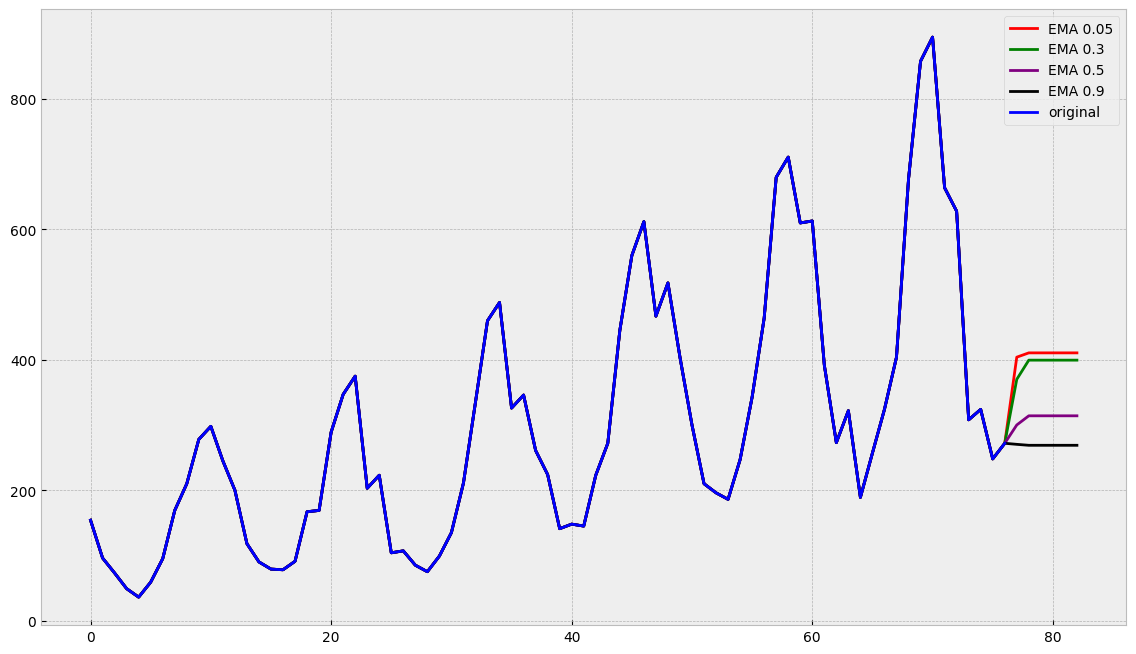

In [366]:
alphas = [0.05,0.3,0.5,0.9]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(sales_of_company_x["Count"], alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.legend()

Daily Female Births

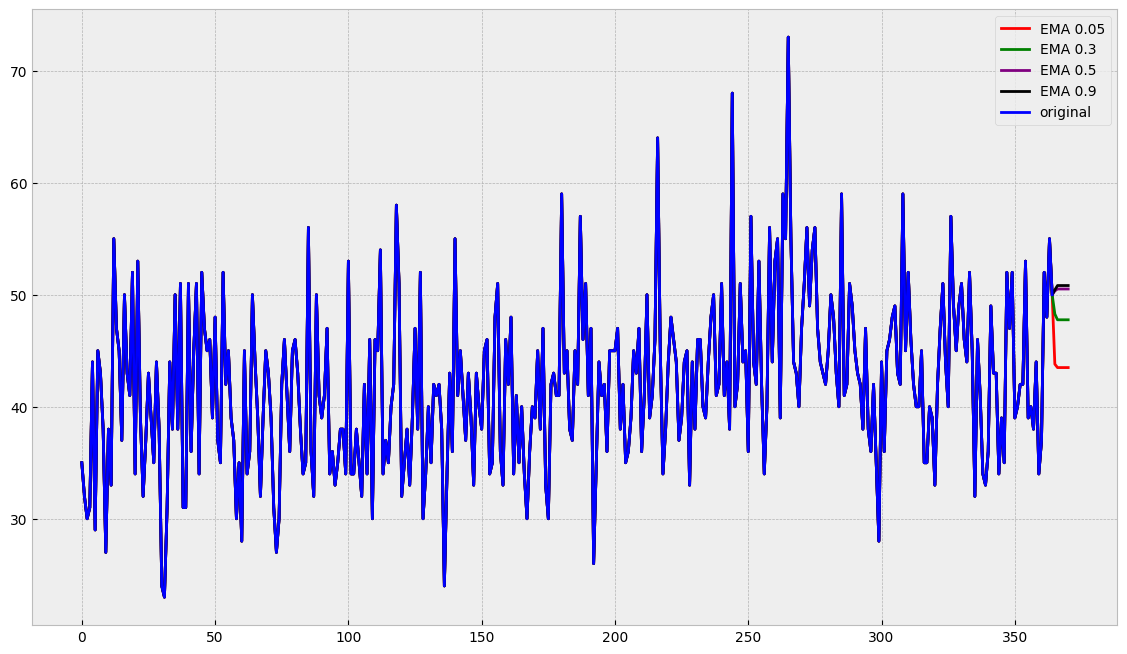

In [367]:
alphas = [0.05,0.3,0.5,0.9]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(female_births["Count"], alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.legend()

6. Двойная EMA

In [368]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.concat([series, pd.Series(preds)], ignore_index=True), pd.Series(result)

Monthly Sales of Company X

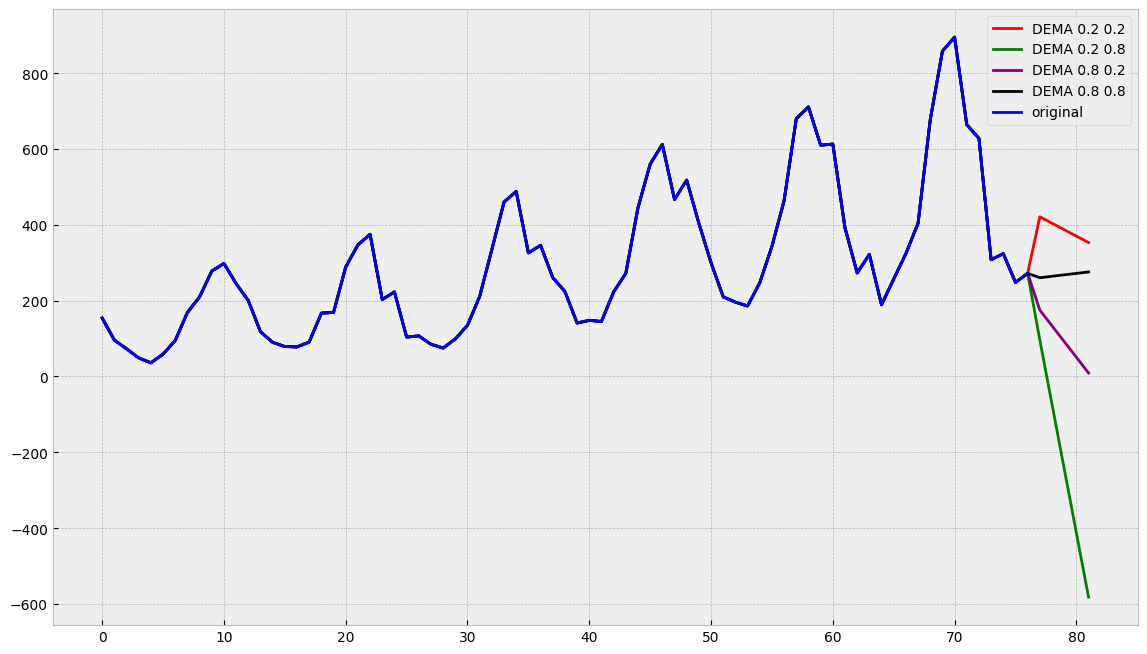

In [369]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(sales_of_company_x["Count"], alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.legend()

Daily Female Births

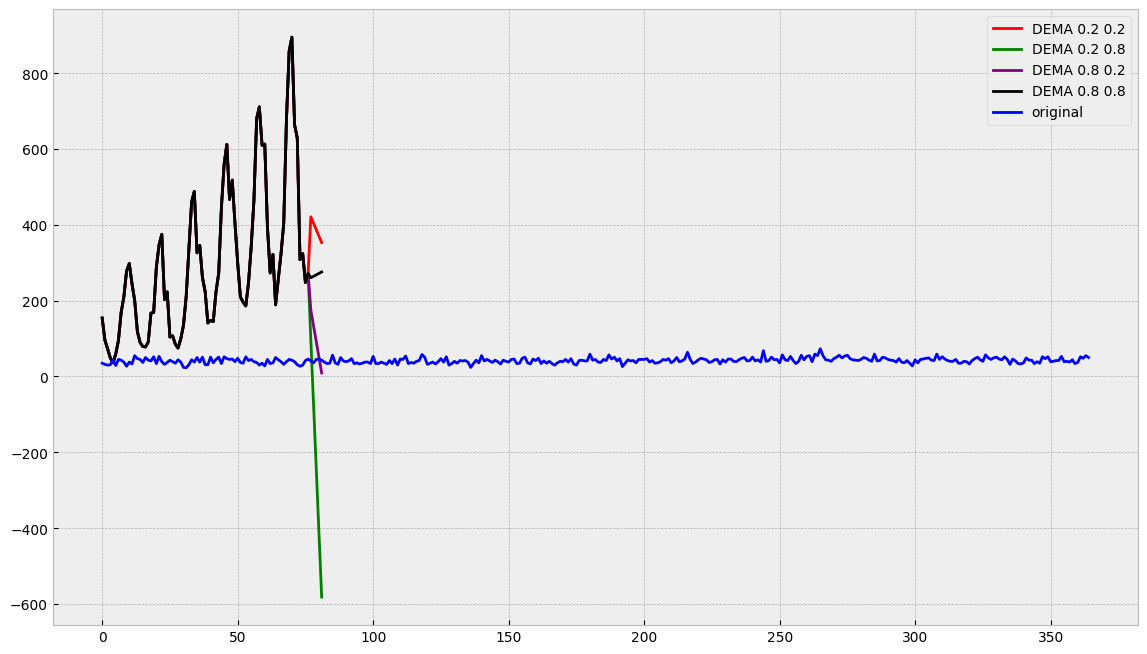

In [370]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(sales_of_company_x["Count"], alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.legend()

7. Хольт-Винтерс

In [371]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [372]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [373]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

Monthly Sales of Company X

In [374]:
def plot_tema_sales(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

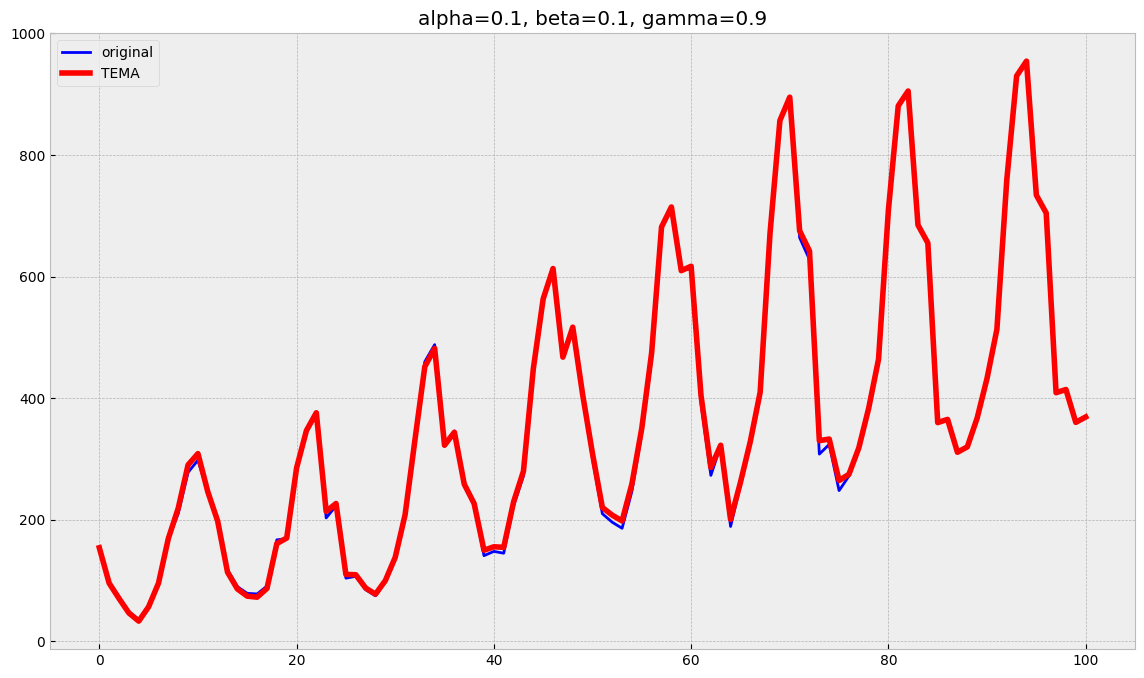

In [399]:
plot_tema_sales(0.1, 0.1, 0.9)

Daily Female Births

In [376]:
def plot_tema_female(alpha, beta, gamma, ser=female_births["Count"], ser_to_plot=female_births["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

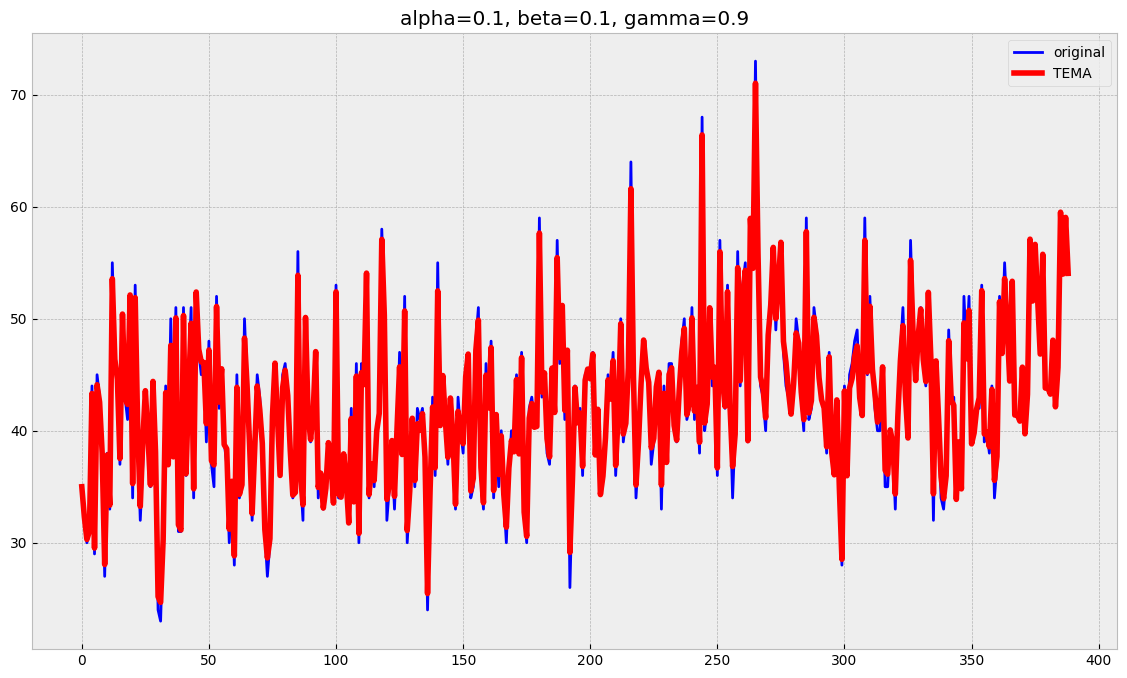

In [398]:
plot_tema_female(0.1, 0.1, 0.9)

Мне больше всего понравился метод Хольта-Винтерса.   
Здесь я максимально подобрал значения для временных рядов. Как видим, эта модель полностью повторяет ряд.


8. Подбор параметров

In [378]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

Monthly Sales of Company X

In [379]:
series_sales = sales_of_company_x["Count"]
len(series_sales)

77

In [380]:
train, test = series_sales[:65], series_sales[65:]

In [381]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [382]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4089.3481390710404
        x: [ 3.589e-01  1.536e-01  1.000e+00]
      nit: 21
      jac: [ 6.821e-04  7.049e-03 -1.210e+03]
     nfev: 116
     njev: 29
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


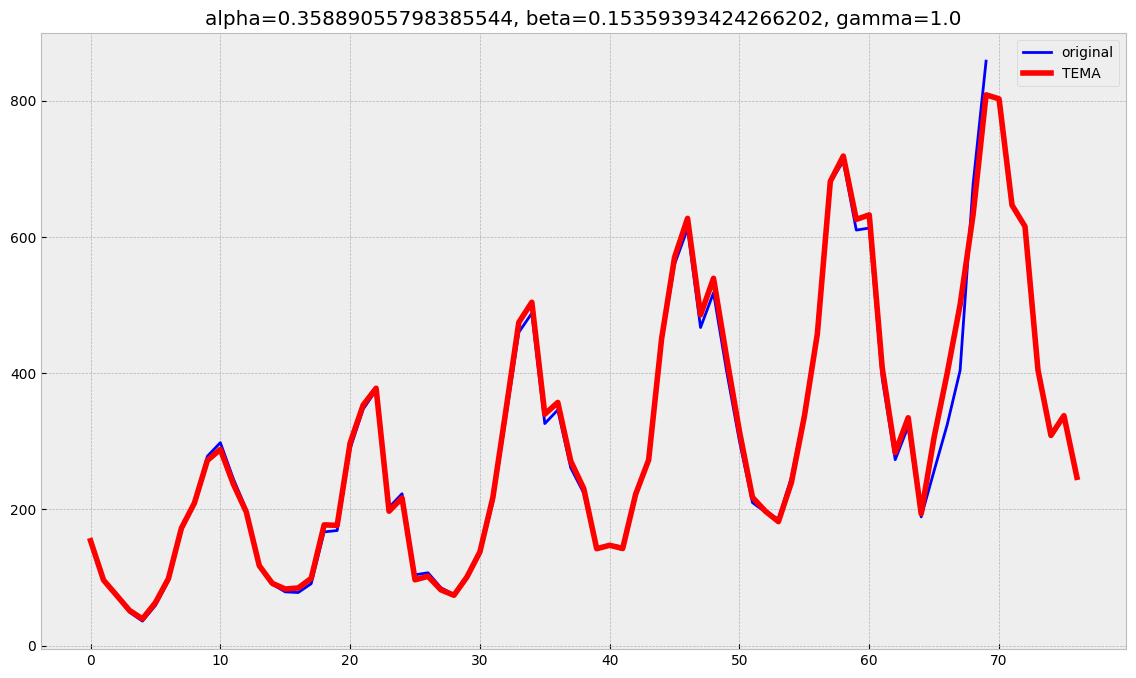

In [383]:
plot_tema_sales(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_sales[:70], n_preds=len(test))

Daily Female Births

In [384]:
series_female = female_births["Count"]
len(series_female)

365

In [401]:
train_, test_= series_female[:300], series_female[300:]

In [386]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4089.3481390710404
        x: [ 3.589e-01  1.536e-01  1.000e+00]
      nit: 21
      jac: [ 6.821e-04  7.049e-03 -1.210e+03]
     nfev: 116
     njev: 29
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


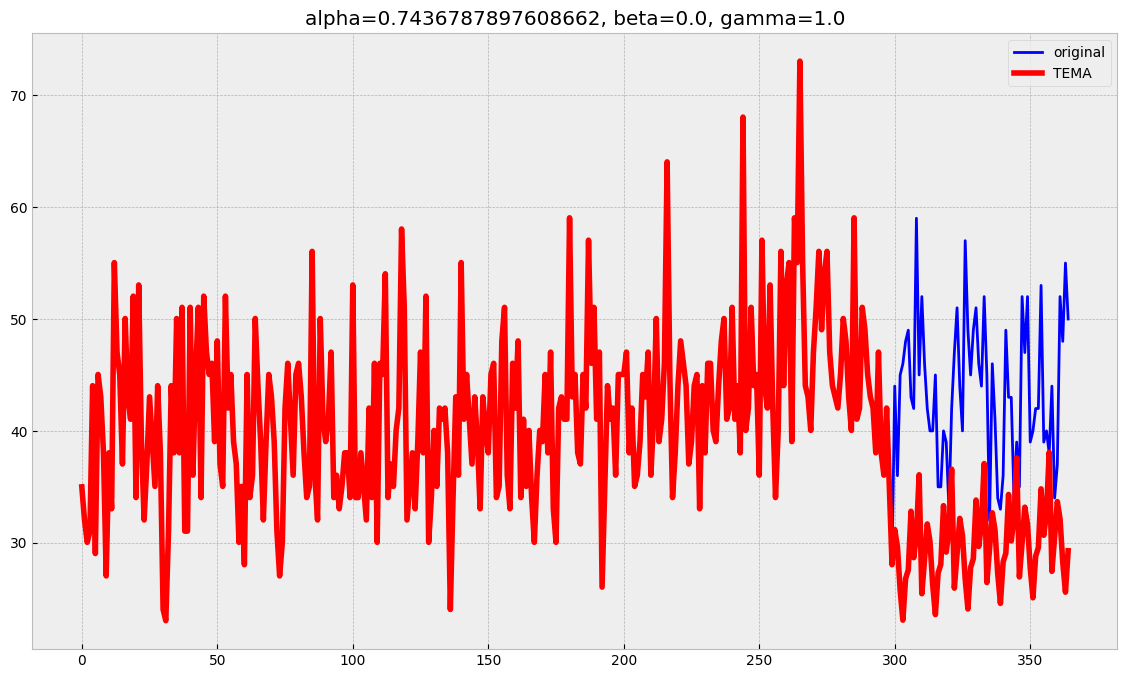

In [404]:
plot_tema_sales(alpha_opt, beta_opt, gamma_opt, ser=train_, ser_to_plot=series_female, n_preds=len(test_))

Подобранные параметры хорошо отработали на не стационарном ряде и плохо отработали на стационарном ряде.

10. Кросс-валидация

Monthly Sales of Company X

In [388]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [389]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

34250.83897569433------------
34106.38472358218------------
34250.83897569433------------
34238.3901472449------------
34146.14699202053------------
34076.670155239895------------
33990.17966916874------------
33924.52831300547------------
33769.59285696624------------
33765.530928050684------------
33578.15072036822------------
33456.37883570149------------
33139.82812575467------------
33011.06373184037------------
32541.065650710396------------
32418.456370546173------------
31780.12502217904------------
31443.50367612731------------
30469.828697809677------------
30145.01938066455------------
28836.123722549615------------
28365.910170950006------------
26651.860659980277------------
25941.814736084332------------
23778.1171684458------------
23090.386170445825------------
20680.550433042168------------
19847.91052680774------------
17400.19153828447------------
16617.357873363715------------
14457.710033107962------------
13851.866207330837------------
12187.298957120998----------

In [390]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7245.772243427314
             x: [ 7.437e-01  0.000e+00  1.000e+00]
           nit: 86
          nfev: 161
 final_simplex: (array([[ 7.437e-01,  0.000e+00,  1.000e+00],
                       [ 7.437e-01,  0.000e+00,  1.000e+00],
                       [ 7.437e-01,  0.000e+00,  1.000e+00],
                       [ 7.438e-01,  0.000e+00,  1.000e+00]]), array([ 7.246e+03,  7.246e+03,  7.246e+03,  7.246e+03]))


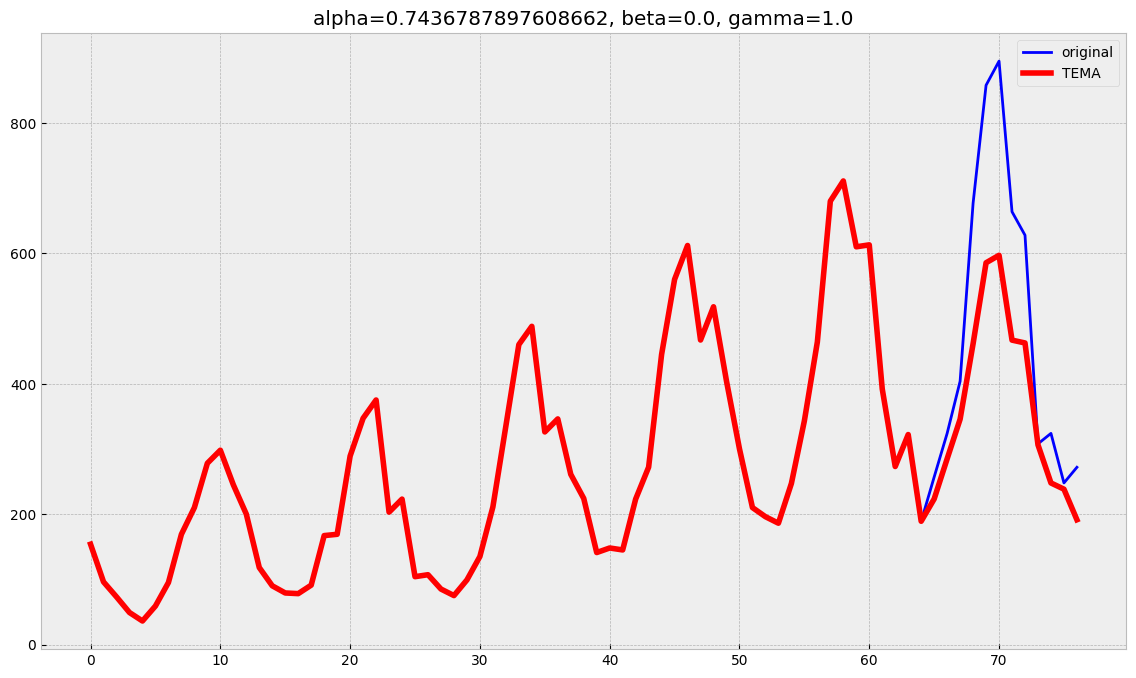

In [391]:
plot_tema_sales(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_sales, n_preds=len(test))

Daily Female Births

In [392]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [393]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

34250.83897569433------------
34106.38472358218------------
34250.83897569433------------
34238.3901472449------------
34146.14699202053------------
34076.670155239895------------
33990.17966916874------------
33924.52831300547------------
33769.59285696624------------
33765.530928050684------------
33578.15072036822------------
33456.37883570149------------
33139.82812575467------------
33011.06373184037------------
32541.065650710396------------
32418.456370546173------------
31780.12502217904------------
31443.50367612731------------
30469.828697809677------------
30145.01938066455------------
28836.123722549615------------
28365.910170950006------------
26651.860659980277------------
25941.814736084332------------
23778.1171684458------------
23090.386170445825------------
20680.550433042168------------
19847.91052680774------------
17400.19153828447------------
16617.357873363715------------
14457.710033107962------------
13851.866207330837------------
12187.298957120998----------

In [394]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7245.772243427314
             x: [ 7.437e-01  0.000e+00  1.000e+00]
           nit: 86
          nfev: 161
 final_simplex: (array([[ 7.437e-01,  0.000e+00,  1.000e+00],
                       [ 7.437e-01,  0.000e+00,  1.000e+00],
                       [ 7.437e-01,  0.000e+00,  1.000e+00],
                       [ 7.438e-01,  0.000e+00,  1.000e+00]]), array([ 7.246e+03,  7.246e+03,  7.246e+03,  7.246e+03]))


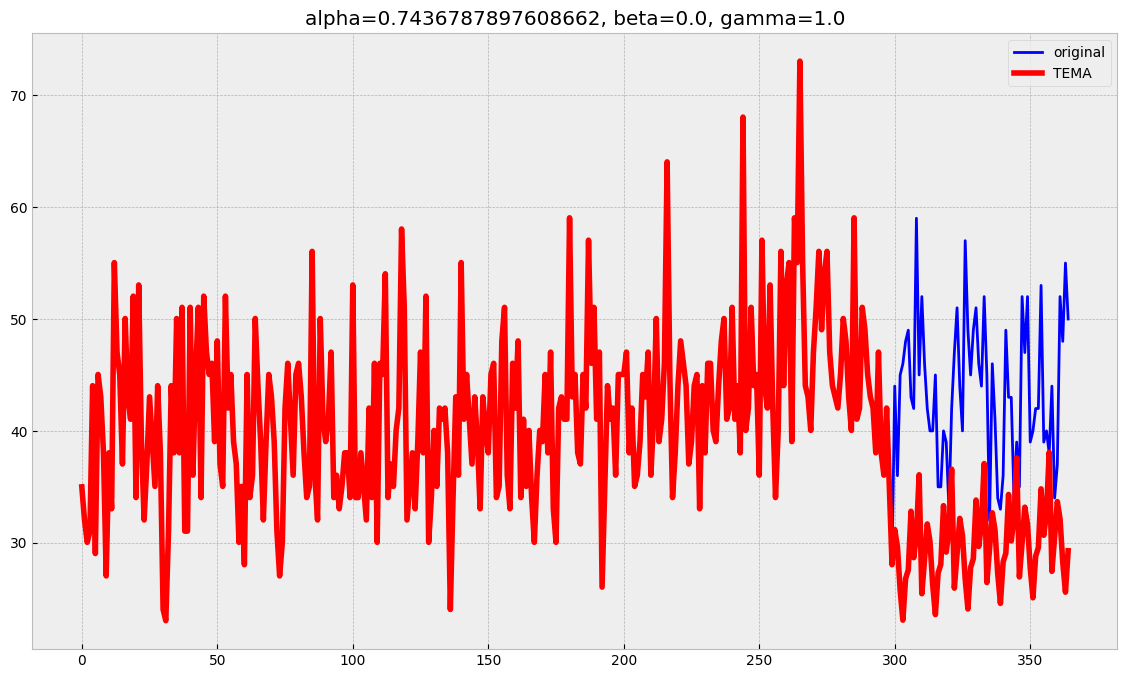

In [395]:
plot_tema_female(alpha_opt, beta_opt, gamma_opt, ser=train_, ser_to_plot=series_female, n_preds=len(test_))